# Introduction

## Motivation

We want to build a model of currency exchange rates for GBP, USD, and JPY. The observed exchange rates are GBPUSD, GBPJPY, USDJPY, and their reciprocals (we assume zero spread). Here, USDJPY = 100 means 1 USD buys us 100 JPY. 

Forecasting each exchange rate separately might imply arbitrage opportunities, inconsistent with the efficient market assumption. Suppose we forecast USDJPY = 100, JPYGBP = 0.01, and GBPUSD = 1.5. Then

$$\frac{USD}{JPY} \times \frac{JPY}{GBP} \times \frac{GBP}{USD} = 100 \times 0.01 \times 1.5 = 1.5$$

We can traverse the path $USD \to JPY \to GBP \to USD$ for 50% profit per cycle with no risk. Generally, arbitrage opportunities do not exist, so these forecasts are inconsistent with the real world.

To satisfy the no-arbitrage constraint, we can model individual currency values and assert the exchange rates are ratios of these hidden values. Even though $\frac{USD}{JPY}$ is written as a fraction, it is a single variable; the fraction is notational convenience. We want the fraction to be an actual ratio of two variables so the variables can "cancel out" and evaluate to 1 no matter the cycle.

We forecast the log of the exchange rates: $log(\frac{USD}{JPY}) = log(USD) - log(JPY)$. This has two major benefits. First, we can express observations as linear combinations of hidden variables. Second, we can explicitly model USD and JPY as geometric Brownian motion.

The second part has some subtleties. We cannot model $X = log(\frac{USD}{JPY})$ as Brownian motion $X_{t+1} - X_t \sim \mathcal N(0, \sigma^2)$ because that implies the exchange rate will keep going up. Recall that if $Y \sim \mathcal N(\mu, \sigma^2)$, then $\mathbb E[e^{Y}] = e^{\mu + \frac 12 \sigma^2} > 1$. If we model both $log(\frac{USD}{JPY})$ and $log(\frac{JPY}{USD})$ as Brownian motion with zero drift, then both exchange rates will go up over time, which is absurd.

However, allowing both $log(USD)$ and $log(JPY)$ go up in value over time is perfectly reasonable. For instance, if USD goes up slower than JPY, but both are going up, then the exchange rate USDJPY will go down. Therefore, allowing an individual currency to be geometric Brownian motion leads to a consistent model. Furthermore, we will be able to tell at a glance which currencies are strengthening or weakening by plotting the latent states over time.

## Data

We obtained 1-minute interval exchange data from __[Philippe Remy's Github](https://github.com/philipperemy/FX-1-Minute-Data)__ and worked on USD, GBP, and JPY exchange rates in May 2019. We took a small sample where the market is continuously open. Missing values are assumed to be missing because the exchange rate has not changed since the last measurement, so we impute with the last observed value.

# (Adaptive) Kalman Filter

The model assumes the observed values y are linear combinations of latent variables x. Here, x is log currency while y is log exchange rate.

$$x_{t+1} = x_{t} + u_t$$
$$y_{t+1} = B x_{t+1} + v_t$$
$$u \sim MVN(0, \Sigma_p)$$
$$v \sim MVN(0, \Sigma_m)$$

For this setup, the Kalman Filter is the optimal estimator. We will limit ourselves to the Gaussian assumption.

## What is a Filter?

A filter only sees past and current data and does not know of the future, whereas smoothing uses future information to make inferences about the present. If we use moving averages, then a sliding window from $t-2$ to $t$ is a filter, while a sliding window from $t-2$ to $t+2$ is a smoother. Visually, a filter looks similar to a smoother. In this illustration, the blue line is the observed values, while the red line is the filtered values.

<img src="gbpusd_example.jpeg" width = "500" />

## Continuous State Space Model

<img src="HMM.png" width = "500" />

__[<center>Image source</center>](http://www.davidsbatista.net/blog/2017/11/11/HHM_and_Naive_Bayes/)__

A Kalman Filter the continuous analog of a Hidden Markov Model. The first equation governs the transition of the hidden states while the second equation governs the emissions. The Kalman Filter is commonly used for navigation systems, so think of the hidden state as your car's true position while the measurements are GPS readings. The continuity further implies that your car cannot teleport.

## Connection to Normal-Normal Conjugacy

Consider a univariate random walk with increments $\mathcal N(0, \sigma^2_p)$ and our measurements have an error $\sim \mathcal N(0, \sigma^2_m)$. 

Then the Kalman Filter reduces to a Normal-Normal conjugacy relationship with unknown mean:

$$\mu_{t+1} = \frac{\frac{1}{Var(\mu_t) + \sigma^2_p} \mu_t + \frac{1}{\sigma^2_m} y}{\frac{1}{Var(\mu_t) + \sigma^2_p} + \frac{1}{\sigma^2_m}}$$       
$$Var(\mu_{t+1}) = \frac{1}{\frac{1}{Var(\mu_t) + \sigma^2_p} + \frac{1}{\sigma^2_m}}$$

The Kalman Filter is the optimal estimator because it gives us the posterior mode = mean = median. We cannot do any better.


## Parameter Estimation

In virtually all real-world cases, the variances are unknown hyperparameters. In the univariate case, the only thing that matters is the ratio $\frac{\sigma^2_m}{\sigma^2_p}$ when your n is large enough. Likewise, for the multivariate case, the simplest model is to set $\Sigma_m = I_m$ and $\Sigma_p = \tau I_p, \tau \in \mathbb R^+$ and the problem reduces to estimating a single parameter. The next step up in complexity is to use the mean-field variational family: diagonal covariance matrices where we estimate each diagonal element separately.

However, a priori, this is too simple. We expect some currencies to be more stable than others, and exchange rates with the same underlying currency should be correlated with each other. In ADVI, it is noted that financial assets have enough complexity that a full covariance matrix tends to perform much better than the mean-field variational family. Therefore, we want to estimate full-rank matrices.

## Adaptivity

Many financial time series exhibit volatility clustering, so models like GARCH are popular in finance. We want to capture this dynamic and let the covariance matrices vary over time. $\Sigma_p$ might increase because of changes in government policy. $\Sigma_m$ might increase in times of market uncertainty.

# Big Problem

We ended up not using Pyro because, as we found out, this problem is not suited for probabilistic programming. The __[Kalman Filter implementation in Pyro](http://docs.pyro.ai/en/stable/contrib.tracking.html#module-pyro.contrib.tracking.extended_kalman_filter)__ require us to supply one covariance, which we are trying to estimate.

Time series models are hard to fit because the likelihood cannot be factored nicely. The most relaxed assumption we can have is at least first-order Markov process. In our case, assuming $\theta$ is all the hyperparameters that are *not* time-varying, the likelihood is

$$ p(Y | X, \theta ) = p(\theta ) p(x_0) \prod_{t=1}^n p(y_t | x_t, \theta ) p(x_t | x_{t-1}, \theta) $$

We cannot evaluate the gradient with respect to $\theta$. The likelihood of the observations can be computed easily when $\theta$ is fixed. However, when $\theta$ changes, so does our estimate of $X$, so it is not clear how a change in $\theta$ might affect the likelihood. Furthermore, automatic differentiation will have to go through the entire time series at every single step, leading to computational issues. 

An EM approach is better-suited for this kind of problem, where we alternate between estimating $\theta$ while holding $X$ fixed and estimating $X$ while holding $\theta$ fixed. Therefore, we do EM the old-fashioned way.

To make matters worse, we cannot use stochastic methods because the observations are not exchangeable, even assuming $\theta$ is fixed. With time-varying $\theta$, stochastic methods go out the window.

# Model Fitting

The pseudocode of the algorithm:

```python
initialize priors with kalman_smoother() on burn-in samples
counter = 1
do:
    iter = 0
    while psis_k < 0.7:
        iter = iter + 1
        forward_pass(data[counter:])
    kalman_smoother(data[counter:(counter + iter)])
    update hyperparameters
    counter = counter + iter
until went through all observations
```

To make the problem tractable, we use the inverse Wishart distribution, which is the distribution of covariance matrices characterized by the $\nu$ degrees of freedom parameter and the $S_{p \times p}$ scale parameter. Intuitively, $\nu$ is the number of observations we pad our prior with, and $S$ is $X^T X$ where $X$ is a $n \times p$ matrix where each row comes from a $MVN(0, \Sigma)$ distribution. The inverse Wishart has mode $\frac{S}{\nu}$ and mean $\frac{S}{\nu - p - 1}$. If this looks like the MLE vs unbiased estimator of variance, you're getting it. Thus, the update is

$$\nu_{t+1} = \nu_t + n$$

$$S_{t+1} = S_t + S_{obs}$$

## Forward Pass

The forward pass estimates the latent variables by supplying a starting point, some observations, and the covariance matrices. We hold hyperparameters fixed and propagate through the system. The calculations are standard and can be found on Wikipedia. We are simply updating our MVN prior with MVN likelihood and then adding some uncertainty at each time step.

## EM Smoothing

Kalman smoothing algorithms provide the best estimates of initial state. However, this will allow currencies to "teleport" from one minibatch to the next. Instead, we use EM to hold the initial state fixed. In the expectation step, we do a forward_pass() to estimate the latent states given the covariances. In the maximization step, we do

$$\hat S_m = (Y-\hat Y)^T (Y-\hat Y)$$

$$\hat S_p = \sum_t (X_t - X_{t-1})^T (X_t - X_{t-1})$$

We iterate EM until convergence and update our inverse Wishart priors using the empirical scale matrices.


## Pareto-Smoothed-Importance-Sampling Leave-Future-Out CV (PSIS-LFO-CV)

PSIS is often used to approximate LOO-CV to assess model fit. PSIS-LFO-CV is a form of approximate LOO-CV for time series models, and the raw importance weights are proportional to

$$r_n^{(s)} \propto \prod_{i=1}^n p(y_{t+i}|\theta^{(s)})$$

Which is the likelihood of the observations given some sampled hyperparameters. In other words, we can sample some covariance matrices and hold them fixed, and given an initial state and some observations, we can go through the forward_pass() and evaluate the likelihood of the observations up to that time point. When the likelihoods start to have infinite variance, our model is becoming unstable because their predictions start to differ wildly, and we have to refit our model. Instead of refitting for the entire past, instead we use the conjugacy of the inverse Wishart to refit only using the data since the last time the model was refitted.

PSIS fits a generalized Pareto distribution to the right tail of the raw importance weights (the highest 20%) with some weakly regularizing prior (because otherwise fitting a GPD can be extremely hard). When the shape parameter $k$ goes above 0.5, the variance of the distribution is infinite. However, in the PSIS-LOO-CV paper, empirically the results are decent until $k > 0.7$, at which point we update our hyperparameters and start a new forward_pass().

## Code

### Data loading and preprocessing

In [2]:
import numpy as np
import pandas as pd
from Report_EM import forward_pass
%run Report_preprocessing.py
%run Report_EM.py

We took logs for each FX rate and multiply them by 100 to avoid numerical issues.

In [3]:
df.head()

,timestamp,gbpjpy,gbpusd,usdjpy,time_gap
0,2019-05-01 00:00:00,497.985989,26.565883,471.39349,1
1,2019-05-01 00:01:00,497.985989,26.565883,471.39349,1
2,2019-05-01 00:02:00,497.985989,26.565883,471.39349,1
3,2019-05-01 00:03:00,497.985989,26.565883,471.39349,1
4,2019-05-01 00:04:00,497.985989,26.565883,471.39349,1


### Running forward pass

In [4]:
training = df.loc[10000:11999, :]

forward_predictions, forward_states, \
    forward_post_covar, forward_innoation_covar = \
    forward_pass(data=training[:100],
                 initial_state=np.array([270, -220, 250]),
                 emit_mat=emit_mat,
                 meas_covar=1 *
                 np.identity(
                 nrow),
                 proc_covar=0.01 *
                 np.identity(
                 nrow),
                 post_covar=0.01*np.identity(nrow))
# Convert to pandas Data Frame
forward_predictions = pd.DataFrame(forward_predictions,
                                   columns=['timestamp'] +
                                   ccy_list + ['time_gap'])

In [38]:
%run Report_utils.py

In [6]:
gbpusd_dict = {'gbpusd(raw)': training.iloc[20:100, 1].shift(-1),
               'gbpusd(pred)': forward_predictions.iloc[20:100, 1].to_numpy()}

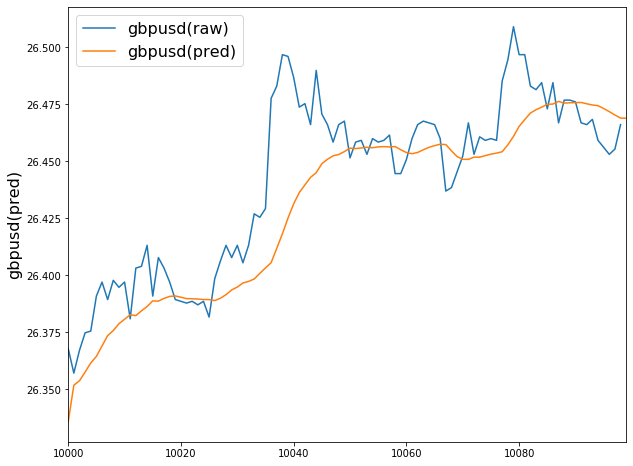

In [16]:
plot_multi(pd.DataFrame(gbpusd_dict), figsize=(10, 8))

### Running Kalman smoother

In [8]:
check_smoother = kalman_smoother(data=training[:1000],
                                 prior_state=np.array(
                                     [270, -220, 250], dtype=np.float64),
                                 emit_mat=emit_mat,
                                 prior_meas_df=100,
                                 prior_meas_scale=1**2 *
                                 np.identity(
                                     emit_mat.shape[1], dtype=np.float64),
                                 prior_proc_df=100,
                                 prior_proc_scale=0.1**2 *
                                 np.identity(
                                     emit_mat.shape[0], dtype=np.float64),
                                 post_covar=forward_post_covar
                                 )

In [9]:
gbpusd_dict = {'gbpusd(raw)':
               check_smoother['input_data'][0:100].loc[:, 'gbpusd'].shift(-1),
               'gbpusd(pred)':
               check_smoother['predicted_measurements'][0:100][:, -3]}

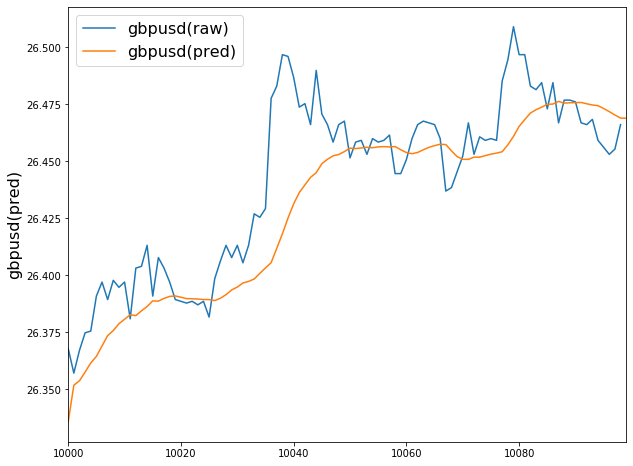

In [10]:
plot_multi(pd.DataFrame(gbpusd_dict), figsize=(10,8))

### Adaptive Kalman Filter

In [11]:
%run Report_adaptive_kf.py

In [12]:
check_smoother_init = kalman_smoother(
    data=df.loc[19499:19998, :],
    emit_mat=emit_mat,
    prior_state=np.array([0, 0, 0], dtype=np.float64),
    post_covar=10*np.identity(emit_mat.shape[0], dtype=np.float64),
    prior_proc_df=10,
    prior_proc_scale=10*0.1*np.identity(emit_mat.shape[0], dtype=np.float64),
    prior_meas_df=10,
    prior_meas_scale=10*0.1*np.identity(emit_mat.shape[0], dtype=np.float64)
)

In [13]:
check_akf = adaptive_kalman_filter(
    data=df.loc[19999:20498, :],
    emit_mat=emit_mat,
    burn_in=0,
    prior_state=check_smoother_init['states'][-1, 1:-1].astype(np.float64),
    prior_covar=check_smoother_init['post_covar'],
    innovation_covar=check_smoother_init['innovation_covar'],
    prior_proc_df=check_smoother_init['post_proc_df'],
    prior_proc_scale=check_smoother_init['post_proc_scale'],
    prior_meas_df=check_smoother_init['post_meas_df'],
    prior_meas_scale=check_smoother_init['post_meas_scale']
)

In [17]:
input_data = check_akf['input_data'].iloc[:, :-1]
input_data.iloc[:, 1:] = input_data.iloc[:, 1:] / 100
predictions = pd.DataFrame(check_akf['predicted_meas'],
                           columns=['timestamp'] + ccy_list + ['timegap'])
predictions.iloc[:, 1:-1] = predictions.iloc[:, 1:-1] / 100
plot_df = pd.merge(how='inner', left=input_data, right=predictions,
                   on='timestamp', suffixes=('_raw', '_pred'))
gbpjpy_dict = {'gbpjpy(raw)':plot_df.loc[:, 'gbpjpy_raw'].shift(-1),
               'gbpjpy(pred)':plot_df.loc[:, 'gbpjpy_pred']}

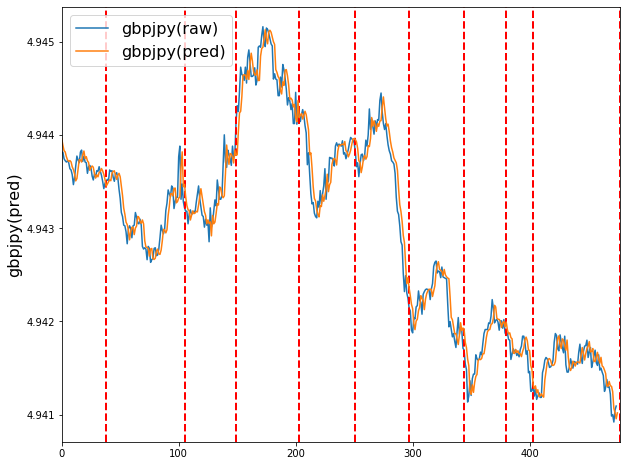

In [15]:
plot_multi(pd.DataFrame(gbpjpy_dict), figsize=(10, 8), vline=check_akf['breakpoints'])

#### Latent states

In [33]:
gbp_lat_states = check_akf['states'][:,1]/100
jpy_lat_states = check_akf['states'][:,2]/100
states_dict = {'GBP_states':gbp_lat_states, 'JPY_states':jpy_lat_states}

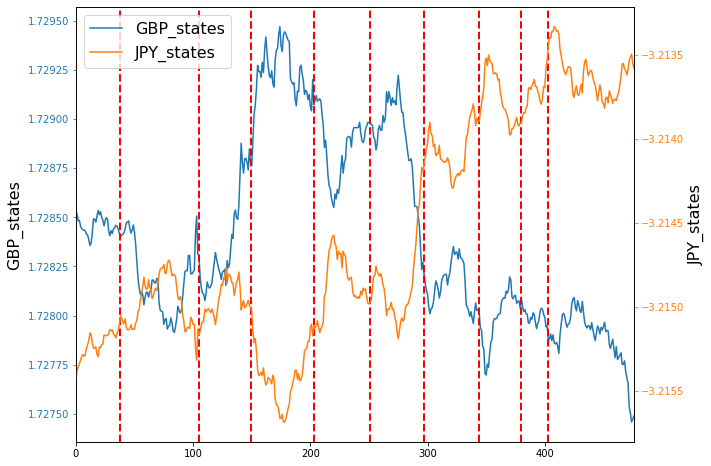

In [39]:
plot_multi_axes(pd.DataFrame(states_dict), figsize=(10, 8), vline=check_akf['breakpoints'])

# Criticism

We started with strong theory and set out to build a model consistent with the theory. Like with many research problems, we didn't know at the start whether or not we'd get a satisfying conclusion. In our case, we are left unsatisfied.

The resulting model updates the covariance matrices over time, but the model implicitly assumes time-invariant covariance matrices. As more data is collected, $\nu$ becomes so big that the prior overwhelms any new data.

In addition, the resulting predictions follow the observations anyway because the exchange rates are too volatile. And when we tried 5 currencies, the model breaks down.

Despite all this, being able to infer which currencies weaken or strengthen relative to other currencies and tying everything together into a no-arbitrage framework is pretty cool.

# References

__[ADVI](https://arxiv.org/pdf/1603.00788.pdf)__ Kucukelbir et al. (2016). Automatic Differentiation Variational Inference

__[PSIS](https://arxiv.org/pdf/1507.02646.pdf)__ Vehtari et al. (2019). Pareto Smoothed Importance Sampling

__[PSIS-LOO-CV](https://arxiv.org/pdf/1507.04544.pdf)__ Vehtari et al. (2016) Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC

__[PSIS-LFO-CV](https://arxiv.org/pdf/1902.06281.pdf)__ Bürkner et al. (2019). Approximate leave-future-out cross-validation for Bayesian time series models

